# Parse Documents

In [20]:
import pandas as pd 
import jsonlines
from tqdm.auto import tqdm

In [21]:
news_file = '../data/bn-news-and-bfw__no-heads.json'
with open(news_file) as f:
    lines = []
    for idx, l in tqdm(enumerate(jsonlines.Reader(f))):
        if l['wire'] == 25:
            lines.append(l)
        

# news_df = pd.read_json(, lines=True, orient='records')

0it [00:00, ?it/s]

In [22]:
from bs4 import BeautifulSoup

In [27]:
beat_news_df = pd.DataFrame(lines)
beat_news_df = (
    beat_news_df
        .assign(body=lambda df: df['body'].apply(lambda x: BeautifulSoup(x).get_text(' ').strip()))
        .assign(body=lambda df: df.apply(lambda x: x['body'].replace(x['headline'], '').strip(), axis=1))
)

In [40]:
(beat_news_df
     .drop(columns=['nicodes', 'wire'])
     .to_csv('../data/beat-news__2022-2023.csv')
)

# Code to Run Taggin

In [ ]:
import pandas as pd 
import sys
data_df = pd.read_csv('../pycharm_project_data/beat-news__2022-2023.csv')
# sys.path.insert(0, '../pycharm_project_377/models/discourse-model/src/')
sys.path.insert(0, '../pycharm_project_172/modeling/quote-type-modeling/src/')
from sentence_model import SentenceClassificationModel as NewsDiscourseModel
from transformers import AutoTokenizer
import spacy
from sentence_model import TokenizedDataset

# model = NewsDiscourseModel.from_pretrained('alex2awesome/newsdiscourse-model')
model = NewsDiscourseModel.from_pretrained('alex2awesome/quote-type-sentence-model')
data_df = pd.read_csv('../pycharm_project_data/beat-news__2022-2023.csv')
tok = AutoTokenizer.from_pretrained('roberta-base')
spacy_model = spacy.load('en_core_web_lg')

In [ ]:
import unidecode
import torch
from util import _get_attention_mask, label_mapper
from torch.nn.utils.rnn import pad_sequence
from util import label_mapper
from tqdm.auto import tqdm
from more_itertools import flatten
import re
import jsonlines

spacy_model.add_pipe('sentencizer')
doc_sentences = []
for doc in spacy_model.pipe(data_df['body'].dropna(), disable=[
    "tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner", "textcat"
]):
    sents = list(map(str, doc.sents))
    sents = list(flatten(map(lambda x: x.split('\n'), sents)))
    sents = list(map(lambda x: unidecode.unidecode(x).strip(), sents))
    sents = list(filter(lambda x: x!= '', sents))
    sents = list(map(lambda x: re.sub(' +', ' ', x), sents))
    doc_sentences.append(sents)

idx2label_mapper = {v:k for k,v in label_mapper.items()}
dataset = TokenizedDataset(doc_list=doc_sentences, tokenizer=tok, do_score=True)

model = model.to('cuda')
all_preds = []
num_labels =  max(label_mapper.values()) + 1 
for idx, s in tqdm(enumerate(doc_sentences)):
    d = dataset.process_one_doc(s)
    if (d[0] is None) or d[1] is None:
        continue 
        
    d = {'input_ids': d[0], 'attention_mask': d[1]}
    d = {k : v.to('cuda') for k, v in d.items()}
    _, logits = model.process_one_doc(**d)
    preds = logits.reshape(len(d['input_ids']), num_labels).argmax(dim=1)
    preds = preds.detach().cpu().numpy()
    preds = list(map(idx2label_mapper.get, preds))
    all_preds.append({
        'discourse_preds': preds,
        'sentences': s,
        'idx': idx
    })

# with open('news-discourse.jsonl', 'w') as f:
#     jsonlines.Writer(f).write_all(all_preds)

with open('quote-types.jsonl', 'w') as f:
    jsonlines.Writer(f).write_all(all_preds)

# Analyze Tags

In [72]:
### news discourse

In [73]:
from more_itertools import flatten
import pandas as pd 
import json

In [74]:
with open('../data/bloomberg-articles/news-discourse.jsonl') as f:
    all_lines = []
    for line in f:
        all_lines.append(json.loads(line))
news_discourse_flattened_df = pd.concat(list(map(pd.DataFrame, all_lines)))

# news_discourse_flattened_df = (
#     news_discourse_df
#         .set_index('idx')
#         .apply(lambda x: list(zip(x['discourse_preds'], x['sentences'])), axis=1)
#         .apply(pd.Series)
#         .unstack()
#         .dropna()
#         .reset_index()
#         .pipe(lambda s: pd.DataFrame(s[0].apply(list).tolist(), index=s['idx'], columns=['tag', 'sentence']))
#         .reset_index().rename(columns={'idx': 'doc_id'})
# )

In [71]:
import pandas as pd 
annotated_news_discourse = pd.read_csv(
    '../models/discourse-model/data/reparsed-newsworthiness-df.csv', index_col=0
)

In [75]:
news_discourse_flattened_df.head(2)

,discourse_preds,sentences,doc_id,sent_idx
0,NA,By Veronica Ek (Bloomberg) --,R6AZ03T0AFB4,0
1,Main,"Essity AB, a Swedish maker of diapers and personal hygiene products, plans to raise prices in all markets and product areas to make up for the rising cost of raw materials, energy and distribution.",R6AZ03T0AFB4,1


Text(0.5, 0, '')

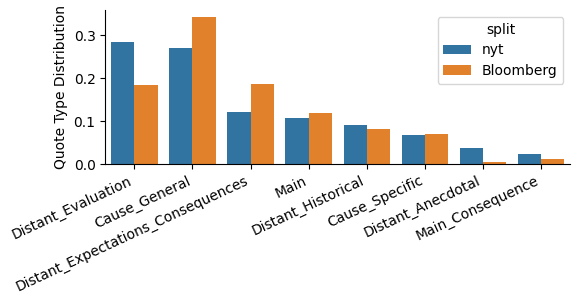

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 

(
    annotated_news_discourse['label']
        .value_counts()
        .sort_values(ascending=False)
        .pipe(lambda s: s/s.sum())
)

f, ax = plt.subplots(1, 1, figsize=(6, 2 ))
(pd.concat([
    (annotated_news_discourse['label']
          .value_counts()
          .sort_values(ascending=False)
          .pipe(lambda s: s/s.sum())
          .to_frame('%')
          .assign(split='nyt')
    ),
    (    news_discourse_flattened_df['discourse_preds']
        .loc[lambda s: s != 'NA']
        .value_counts()
        .sort_values(ascending=False)
        .pipe(lambda s: s/s.sum())
     .to_frame('%')
     .assign(split='Bloomberg')     
    )
])
.reset_index()
.pipe(lambda df: sns.barplot(data=df, x='index', y='%', hue='split', ax=ax))
)
plt.xticks(rotation=25, horizontalalignment='right');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Quote Type Distribution')
plt.xlabel('')

In [33]:

# (news_discourse_flattened_df
#      .groupby(['doc_id'])['tag']
#      .value_counts()
#      .unstack()
#      .fillna(0)
#      .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
#      .mean()
# #      .sort_values(ascending=False)
# #      .unstack()
# )


# news_discourse_df.loc[lambda df: df['idx'] == 3]['sentences'].iloc[0]

In [48]:
doc_ids = news_discourse_flattened_df['doc_id'].drop_duplicates().tolist()
pd.options.display.max_colwidth = 500

In [49]:
print('Cause_General Examples')
(news_discourse_flattened_df
 .sort_values('doc_id')
 .loc[lambda df: df['discourse_preds'] == 'Cause_General']
 [['sentences']]
 .head()
)

Cause_General Examples


,sentences
6,"The country is a key growth market for Google's search and advertising businesses as well as for others such as Facebook Inc., Amazon.com Inc. and Netflix Inc. as the only billion-people-plus country that's still open to foreign firms."
0,Crisis in Vienna could lead to spike in Persian Gulf tensions Iran's oil exports remain under punishing American sanctions
8,A final text is essentially ready and on the table.
7,Hospitalization and intensive care numbers have similarly dipped.
6,"Singapore, with one of the world's highest vaccination rates, is pushing ahead with its strategy to treat the virus as endemic without overwhelming the health-care system or suffering the death toll seen in Europe and the U.S. The city state's infections have dropped to just hundreds of cases a day in the past week compared with the thousands it was reporting for months as it battled a wave of the delta variant of the virus."


In [50]:
print('Distant_Evaluation Examples')
news_discourse_flattened_df.loc[lambda df: df['discourse_preds'] == 'Distant_Evaluation'][['sentences']].head()

Distant_Evaluation Examples


,sentences
2,"Those costs are ""historically high"" at the moment, and there's also nothing to indicate they will come down in the near term, the company said in a statement on Wednesday."
2,"McDonald's says it will evaluate Carl Icahn's board nominees, Leslie Samuelrich and Maisie Ganzler, as it would any other candidates. """
4,"Mr. Icahn's ownership provides him with unique exposure to the industry-wide challenges and opportunities in migrating away from gestation crates."" """
7,"Furthermore, it reflects a departure from the veterinary science used for large-scale production throughout the industry, and would harm the Company's shared pursuit of providing customers with high quality products at accessible prices"" Icahn said Feb. 16 in an interview with Bloomberg TV he was close to nominating a slate because of his concern over the issue of housing pregnant pigs in small crates To view the source of this information, click here"
4,"The stakes are high for Austria, which gets about 80% of its gas from export giant Gazprom PJSC. """


In [51]:
print('Distant_Expectations_Consequences Examples')
(news_discourse_flattened_df
 .loc[lambda df: df['discourse_preds'] == 'Distant_Expectations_Consequences']
 [['sentences']]
 .head()
)

Distant_Expectations_Consequences Examples


,sentences
4,"""Price increases are therefore essential to compensate for the higher costs,"" said Chief Executive Magnus Groth, adding that he would also be looking for efficiency measures to achieve savings."
8,"Essity set a new target to grow sales by more than 5%, saying it will prioritize growth in categories with the highest profitability."
6,"While the Company looks forward to promoting further collaboration across the industry on this issue, the current pork supply in the U.S. would make this type of commitment impossible."" """
4,"The unit will make additional payments in 2023 and 2026, subject to achieving revenue and profitability parameters in the respective previous years."
5,The deal is expected to close in the second half of the year.


In [52]:
pd.options.display.max_colwidth = 500

In [59]:
(news_discourse_flattened_df
     .loc[lambda df: df['discourse_preds'].isin(['Main', 'Cause_General'])]
     .sort_values(['doc_id', 'discourse_preds',] , ascending=False)
     .set_index('doc_id')
     .loc[doc_ids[4]]
#      .to_dict(orent='records')
)

,discourse_preds,sentences,sent_idx
doc_id,,,
RD1ZJ2DWRGG1,Main,"Carl Icahn will end a proxy fight focused on the treatment of pregnant pigs at grocery-chain Kroger Co. after losing a similar battle with McDonald's Corp. last month, according to a person familiar with the matter.",1
RD1ZJ2DWRGG1,Cause_General,The dispute revolves around the practice of keeping sows in individual pens so small that they can't lie down or turn around.,3
RD1ZJ2DWRGG1,Cause_General,His McDonald's nominees lost in a shareholder vote last month.,5


In [60]:
(
    news_discourse_flattened_df
     .loc[lambda df: df['discourse_preds'].isin(['Main', 'Distant_Expectations_Consequences'])]
     .sort_values(['doc_id', 'discourse_preds',] , ascending=False)
     .set_index('doc_id')
     .loc[doc_ids[0]]
#      .to_dict(orient='records')
)

,discourse_preds,sentences,sent_idx
doc_id,,,
R6AZ03T0AFB4,Main,"Essity AB, a Swedish maker of diapers and personal hygiene products, plans to raise prices in all markets and product areas to make up for the rising cost of raw materials, energy and distribution.",1
R6AZ03T0AFB4,Distant_Expectations_Consequences,"""Price increases are therefore essential to compensate for the higher costs,"" said Chief Executive Magnus Groth, adding that he would also be looking for efficiency measures to achieve savings.",4
R6AZ03T0AFB4,Distant_Expectations_Consequences,"Essity set a new target to grow sales by more than 5%, saying it will prioritize growth in categories with the highest profitability.",8


In [93]:
## quote type

In [94]:
quote_type_df = pd.read_json('../data/quote-types.jsonl', orient='records', lines=True)

In [96]:
quote_type_df.head(2)

,discourse_preds,sentences,idx
0,"[Background/Narrative, Statement/Public Speech...","[By Veronica Ek (Bloomberg) -- \n Essity AB ,...",0
1,"[No Quote, Statement/Public Speech, Statement/...",[By Jim Silver (Bloomberg) -- \n (Corrects fi...,1


In [97]:
quote_type_flattened_df = (
    quote_type_df
        .set_index('idx')
         .apply(lambda x: list(zip(x['discourse_preds'], x['sentences'])), axis=1)
        .apply(pd.Series)
        .unstack()
        .dropna()
        .reset_index()
        .pipe(lambda s: pd.DataFrame(s[0].apply(list).tolist(), index=s['idx'], columns=['tag', 'sentence']))
        .reset_index().rename(columns={'idx': 'doc_id'})
)

In [99]:
(
    quote_type_flattened_df['tag']
        .value_counts()
        .sort_values(ascending=False)
)

(quote_type_flattened_df
     .groupby(['doc_id'])['tag']
     .value_counts()
     .unstack()
     .fillna(0)
     .mean()
     .sort_values(ascending=False)
)

tag
No Quote                       11592
Statement/Public Speech         4190
Published Work/Press Report     2646
Direct Quote                    1551
Other                           1515
Indirect Quote                  1220
Background/Narrative            1141
Email/Social Media Post          627
Proposal/Order/Law               387
Court Proceeding                 142
Name: count, dtype: int64

In [108]:
quote_type_flattened_df.loc[lambda df: df['tag']== 'Statement/Public Speech']['sentence'].iloc[1]

'By  Jim Silver (Bloomberg) -- \n Tesla Inc. said a Bitcoin impairment affected its second-quarter earnings and that it has converted about 75% of its Bitcoin purchases into fiat currency.'

In [105]:
quote_type_flattened_df.loc[lambda df: df['tag']== 'Published Work/Press Report']['sentence'].iloc[0]

'By  Foster Wong (Bloomberg) -- \n McKinsey, Bain and Boston Consulting Group have raised salaries for new hires by the most in two decades amid rising competition for talent, the Financial Times newspaper  reported  on Saturday.'

In [103]:
quote_type_flattened_df['doc_id'].value_counts().mean()

12.580985915492958

# Source Analysis

In [11]:
import xopen
import json
import pandas as pd 
import seaborn as sns

In [12]:
annotation_df = pd.read_csv(
    '../../../usc-research/source-type-modeling/data/full-source-classification-annotated-data-df.csv',
    index_col=0
).loc[lambda df: df['sent'].str.len() > 1]

In [14]:
news_doc_df = []
with xopen.xopen('../data/bloomberg-articles/bloomberg-beat-news-source-annotations__0-0__.jsonl.gz') as f:
    for line in f:
        t = json.loads(line)
        news_doc_df.append(pd.DataFrame(t))

In [15]:
full_news_doc_df = pd.concat(news_doc_df)

Text(0, 0.5, '')

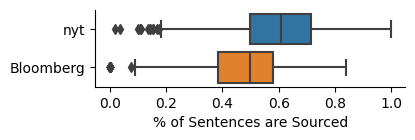

In [305]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(1, 1, figsize=(4,1 ))
(
    pd.concat([
        (annotation_df
             .assign(is_quote=lambda df: df['quote_type'] != 'No Quote')
             .groupby('doc_id')
             ['is_quote'].mean()
             .to_frame('%')
             .assign(split='nyt')
        ),
        (
            full_news_doc_df
                .groupby('doc_idx')
                ['is_quote']
                .mean()
                .to_frame('%')
                .assign(split='Bloomberg')
        )
        
    ])
    
    .pipe(lambda df: sns.boxplot(data=df, y='split', x='%', orient='h', ax=ax))
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('% of Sentences are Sourced')
plt.ylabel('')

Text(0, 0.5, '')

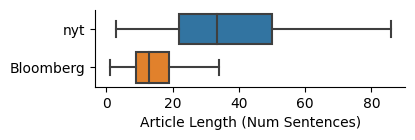

In [307]:
f, ax = plt.subplots(1, 1, figsize=(4,1 ))
(
    pd.concat([
        annotation_df['doc_id']
            .value_counts()
            .to_frame('num sents')
            .assign(split='nyt')
        ,
        full_news_doc_df['doc_idx']
            .value_counts()
            .to_frame('num sents')
            .assign(split='Bloomberg')
    ])
    .pipe(lambda df: sns.boxplot(data=df, x='num sents', y='split', orient='h', showfliers=False, ax=ax))
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Article Length (Num Sentences)')
plt.ylabel('')

Text(0.5, 0, '')

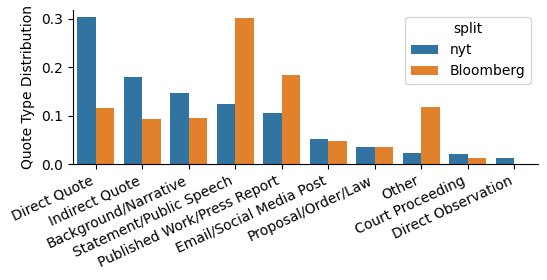

In [330]:
f, ax = plt.subplots(1, 1, figsize=(6, 2 ))
(pd.concat([
    (annotation_df['quote_type']
         .loc[lambda s: s != 'No Quote']
         .value_counts()
         .pipe(lambda s: s / s.sum())
         .to_frame('%')
         .assign(split='nyt')
    ),
    (full_news_doc_df['quote_type']
     .loc[lambda s: s != 'No Quote']
     .value_counts()
     .pipe(lambda s: s/s.sum())
     .to_frame('%')
     .assign(split='Bloomberg')     
    )
])
.reset_index()
.pipe(lambda df: sns.barplot(data=df, x='quote_type', y='%', hue='split', ax=ax))
)
plt.xticks(rotation=25, horizontalalignment='right');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Quote Type Distribution')
plt.xlabel('')

Text(0, 0.5, '')

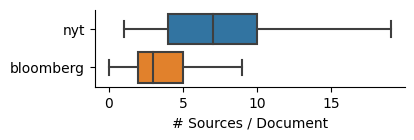

In [356]:
f, ax = plt.subplots(1, 1, figsize=(4,1 ))
(
    pd.concat([
            (annotation_df
                 [['head', 'doc_id']]
                 .drop_duplicates()
                 .dropna()['doc_id']
                 .value_counts()
                 .to_frame('num sources / doc')
                 .assign(split='nyt')
            ),
            (full_news_doc_df
                 .groupby('doc_idx')['attribution']
                 .aggregate(list)
                 .apply(set).str.len()
                 .pipe(lambda s: s - 1)
                 .to_frame('num sources / doc')
                 .assign(split='bloomberg')             
            )
        ])
        .pipe(lambda df: sns.boxplot(data=df, x='num sources / doc', y='split', orient='h', showfliers=False, ax=ax))             
        )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('# Sources / Document')
plt.ylabel('')

# Source Level Analysis

In [18]:
import xopen
import json
import pandas as pd 
import matplotlib.pyplot as plt 

In [19]:
source_doc_df = []
with xopen.xopen('../data/bloomberg-articles/bloomberg-beat-news-source-characteristics.jsonl.gz') as f:
    for line in f:
        t = json.loads(line)
        source_doc_df.append(pd.DataFrame(t))

In [20]:
source_type_mapper = {
    'Other: Vote/Poll': 'Vote/Poll',
    'Other: Database': 'Database',
    'Other: author': 'Named Individual',
}
affiliation_mapper = {
    'Other: Mr. Clinton': 'Government',
    'Named Individual': 'Government',
    'Other: author': 'Cannot Determine'
}
role_mapper = {
    'Other: Mr. Clinton': 'Government',
    'Named Individual': 'Government',
    'Other: author': 'Cannot Determine'
}


In [21]:
full_source_doc_df = (
    pd.concat(source_doc_df)
        .loc[lambda df: df['name'].notnull()]
        .rename(columns={'source-type': 'source_type'})
)

annotation_source_doc_df = annotation_df.dropna()
annotation_source_doc_df = (annotation_source_doc_df
 .assign(source_type=lambda df: df['source_type'].apply(lambda x: source_type_mapper.get(x, x)))
 .assign(affiliation=lambda df: df['affiliation'].apply(lambda x: affiliation_mapper.get(x, x)))
 .assign(role=lambda df: df['role'].apply(lambda x: role_mapper.get(x, x))) 
)

/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_76507/2965524442.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


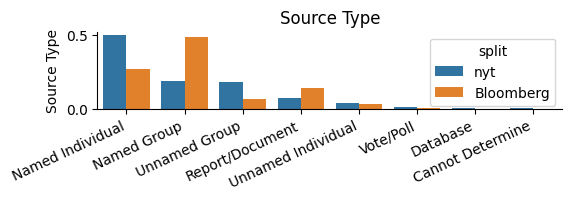

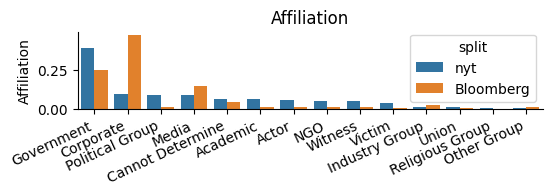

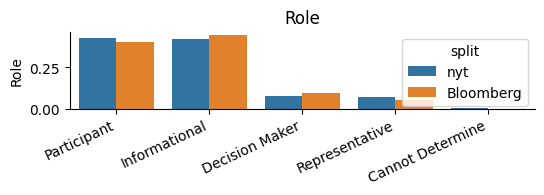

In [29]:
for idx, (col, label) in enumerate([
    ('source_type', 'Source Type'),
    ('affiliation', 'Affiliation'),
    ('role', 'Role')
]):
    f, ax = plt.subplots(1, 1, figsize=(6, 1))
    (pd.concat([
        (annotation_source_doc_df[col]
             .value_counts()
             .pipe(lambda s: s / s.sum())
             .to_frame('%')
             .assign(split='nyt')
        ),
        (full_source_doc_df[col]
         .value_counts()
         .pipe(lambda s: s/s.sum())
         .to_frame('%')
         .assign(split='Bloomberg')     
        )
    ])
    .reset_index()
    .pipe(lambda df: sns.barplot(data=df, x=col, y='%', hue='split', ax=ax))
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel('')
    ax.set_title(label)
    
plt.tight_layout()

/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_76507/216267367.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


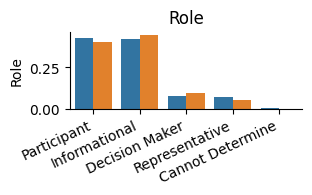

In [34]:
for idx, (col, label) in enumerate([
#     ('source_type', 'Source Type'),
#     ('affiliation', 'Affiliation'),
    ('role', 'Role')
]):
    f, ax = plt.subplots(1, 1, figsize=(3, 1))
    (pd.concat([
        (annotation_source_doc_df[col]
             .value_counts()
             .pipe(lambda s: s / s.sum())
             .to_frame('%')
             .assign(split='nyt')
        ),
        (full_source_doc_df[col]
         .value_counts()
         .pipe(lambda s: s/s.sum())
         .to_frame('%')
         .assign(split='Bloomberg')     
        )
    ])
    .reset_index()
    .pipe(lambda df: sns.barplot(data=df, x=col, y='%', hue='split', ax=ax))
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel('')
    ax.set_title(label)
    ax.legend().set_visible(False)
    
plt.tight_layout()

/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_76507/3334144085.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


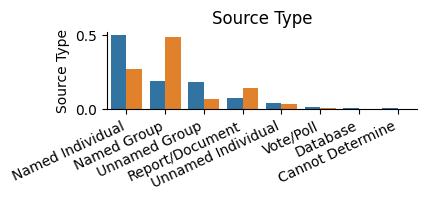

In [36]:
for idx, (col, label) in enumerate([
    ('source_type', 'Source Type'),
#     ('affiliation', 'Affiliation'),
#     ('role', 'Role')
]):
    f, ax = plt.subplots(1, 1, figsize=(4, 1))
    (pd.concat([
        (annotation_source_doc_df[col]
             .value_counts()
             .pipe(lambda s: s / s.sum())
             .to_frame('%')
             .assign(split='nyt')
        ),
        (full_source_doc_df[col]
         .value_counts()
         .pipe(lambda s: s/s.sum())
         .to_frame('%')
         .assign(split='Bloomberg')     
        )
    ])
    .reset_index()
    .pipe(lambda df: sns.barplot(data=df, x=col, y='%', hue='split', ax=ax))
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(label)
    ax.set_xlabel('')
    ax.set_title(label)
    ax.legend().set_visible(False)
    
plt.tight_layout()